# Sentiment Analysis from Twitter Financial News Dataset #

In [1]:
!pip install nltk scikit-learn transformers 

In [2]:
# Import libraries
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset
import pandas as pd
import random as r
from transformers import BertTokenizer, \
BertForSequenceClassification, \
RobertaTokenizer, \
RobertaForSequenceClassification, \
AdamW, \
get_linear_schedule_with_warmup
import re
import nltk

In [3]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords

## Data exploration ##

In [5]:
# Load dataset from huggingface
tfn_dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
df_train, df_dev = pd.DataFrame(tfn_dataset['train']), pd.DataFrame(tfn_dataset['validation'])

README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

sent_train.csv:   0%|          | 0.00/859k [00:00<?, ?B/s]

sent_valid.csv:   0%|          | 0.00/217k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [6]:
tfn_df = pd.concat([df_train, df_dev], ignore_index=True)
tfn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11931 entries, 0 to 11930
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11931 non-null  object
 1   label   11931 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 186.5+ KB


We can see that there is no missing value in Twitter Finance News Dataset. 

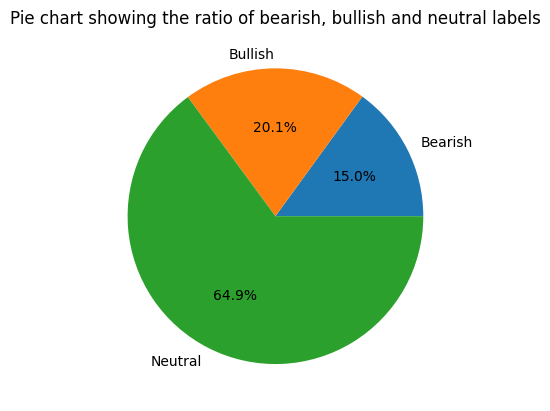

In [7]:
# Count the number of classes
value_stats = tfn_df['label'].value_counts()

# Get values for the chart
values = [value_stats[0], value_stats[1], value_stats[2]]

# Mapping the labels
label_names = {
    value_stats.index[0]: 'Bearish',
    value_stats.index[1]: 'Bullish',
    value_stats.index[2]: 'Neutral'
}

# Create a pie chart
plt.pie(values, labels=label_names.values(), autopct='%1.1f%%')
plt.title('Pie chart showing the ratio of bearish, bullish and neutral labels')
plt.show()

We can see that the dataset is imbalanced and most tweets are neutral.

## Preprocessing data and splitting into train/dev/test

In [8]:
# Text preprocessing
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower() 
    
    # Replace weird characters and links with no character
    text = re.sub(r'\$[A-Za-z]+', '', text) 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text) 
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    
    # Tokenize text
    words = text.strip().split()
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    return text

df_train['text'] = df_train['text'].apply(preprocess_text)
df_dev['text'] = df_dev['text'].apply(preprocess_text)
df_train['text'].values

array(['jpmorgan reels expectations beyond meat',
       'nomura points bookings weakness carnival royal caribbean',
       'cemex cut credit suisse jp morgan weak building outlook', ...,
       'vtv therapeutics leads healthcare gainers myomo biohaven pharmaceutical among losers',
       'work xpo pyx amkr among hour movers',
       'yndx qd oesx among tech movers'], dtype=object)

In [9]:
from sklearn.model_selection import train_test_split
# Split dataset into train/dev/test sets (just split validation dataset (dev dataset) into dev/test sets)
X_train, X_dev, y_train, y_dev = train_test_split(tfn_df['text'], tfn_df['label'], test_size=0.2, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)  

In [10]:
print("Size of Train set: ", len(X_train))
print("Size of Dev set: ", len(X_dev))
print("Size of Test set: ", len(X_test))

Size of Train set:  9544
Size of Dev set:  1193
Size of Test set:  1194


## RoBERTa ##

I utilize RoBERTa for analyzing sentiment from Tweet Financial News dataset. After training and testing, I will save model for building and demonstrating a web app for finance-related tweets sentiment analyst.

In [11]:
MAX_LEN = 128
BATCH_SIZE = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
X_train_roberta, X_dev_roberta, X_test_roberta = X_train, X_dev, X_test
y_train_roberta, y_dev_roberta, y_test_roberta = y_train, y_dev, y_test

In [13]:
roberta_tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base", do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
# Dataset class
class tweetFinancialNews(Dataset):

    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, txt_lbl_idx):
        text = self.texts[txt_lbl_idx]
        label = self.labels[txt_lbl_idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
          'review_text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [15]:
roberta_train_dts = tweetFinancialNews(X_train_roberta.to_numpy(), y_train_roberta.to_numpy(), roberta_tokenizer, MAX_LEN)
roberta_dev_dts = tweetFinancialNews(X_dev_roberta.to_numpy(), y_dev_roberta.to_numpy(), roberta_tokenizer, MAX_LEN)
roberta_test_dts = tweetFinancialNews(X_test_roberta.to_numpy(), y_test_roberta.to_numpy(), roberta_tokenizer, MAX_LEN)

In [16]:
roberta_train_dataloader = DataLoader(roberta_train_dts, batch_size=BATCH_SIZE)
roberta_dev_dataloader = DataLoader(roberta_dev_dts, batch_size=BATCH_SIZE)
roberta_test_dataloader = DataLoader(roberta_test_dts, batch_size=BATCH_SIZE)

In [17]:
roberta_model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=3)
roberta_model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [18]:
ROBERTA_EPOCHS = 3 # epoch for RoBERTa

roberta_opt = AdamW(roberta_model.parameters(), lr = 2e-5, eps=1e-8) # optimizer
roberta_num_steps = len(roberta_train_dataloader) * ROBERTA_EPOCHS 

scheduler = get_linear_schedule_with_warmup(
  roberta_opt,
  num_warmup_steps=500, # learning rate will increase from 0 to 2e-5 in 500 steps and go down to 0 in the remaining time
  num_training_steps=roberta_num_steps
)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def pt_train(model, train_dataloader, opt, device, scheduler):
    model.train()    # A model starts training
    losses = []
    
    for data in train_dataloader:
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        train_output = model(input_ids=input_ids, attention_mask=attention_mask, labels = labels)
        
        #loss = classification loss
        loss = train_output.loss

        losses.append(loss.item())
        loss.backward()   # performs backpropagation(computes derivates of loss w.r.t to parameters)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #clipping gradients 
        opt.step()       #After gradients are computed by loss.backward() this makes the optimizer iterate over all parameters it is supposed to update and use internally #stored grad to update their values
        scheduler.step()    # Make sure learning rate changes (If we do not use this line, the learning rate will stay at initial value)
        opt.zero_grad()     # clears old gradients from last step

        
    return np.mean(losses)

In [ ]:
def pt_eval(model, dev_dataloader, device):  
    model.eval()   # A model is in validation mode
    losses = []

    with torch.no_grad():
        for data in dev_dataloader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["labels"].to(device)
            dev_output = model(input_ids=input_ids, attention_mask=attention_mask, labels = labels)
            
            loss = dev_output.loss
            losses.append(loss.item())

    return  np.mean(losses)

In [ ]:
def predict(model, test_dataloader):
    model.eval()

    predictions, real_values = [], []

    with torch.no_grad():
        for data in test_dataloader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["labels"].to(device)

            test_output = model(input_ids=input_ids,attention_mask=attention_mask, labels=labels)
            logits = test_output.logits
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            predictions.append(logits)
            real_values.append(label_ids)

    y_test = real_values
    y_pred = [np.argmax(predictions[i], axis=1).flatten() for i in range(len(real_values))]
    return y_test, y_pred

In [22]:
from collections import defaultdict

roberta_history = defaultdict(list)

for rbt_epoch in range(ROBERTA_EPOCHS):
    print(f'Epoch {rbt_epoch + 1}/{ROBERTA_EPOCHS}')
    print('-' * 10)
    
    rbt_train_loss = pt_train(roberta_model, roberta_train_dataloader, roberta_opt, device, scheduler)

    print(f'Train loss {rbt_train_loss}')

    rbt_dev_loss = pt_eval(roberta_model, roberta_dev_dataloader, device)

    print(f'Val   loss {rbt_dev_loss}')
    print()

    roberta_history['epoch'].append(rbt_epoch)
    roberta_history['train_loss'].append(rbt_train_loss)
    roberta_history['dev_loss'].append(rbt_dev_loss)

roberta_history

Epoch 1/3
----------
Train loss 0.6833958595393095
Val   loss 0.3620868775209314

Epoch 2/3
----------
Train loss 0.33222754608627947
Val   loss 0.33752091228961945

Epoch 3/3
----------
Train loss 0.20175598686978372
Val   loss 0.32111352091459067



defaultdict(list,
            {'epoch': [0, 1, 2],
             'train_loss': [0.6833958595393095,
              0.33222754608627947,
              0.20175598686978372],
             'dev_loss': [0.3620868775209314,
              0.33752091228961945,
              0.32111352091459067]})

([<matplotlib.axis.YTick at 0x7a297031f430>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.6, '1.6'),
  Text(0, 2.0, '2.0')])

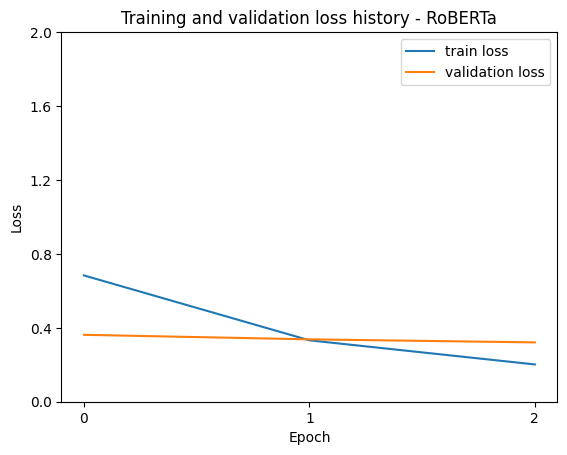

In [23]:
# Visualize from result of training and validation loss of BERT
plt.plot(roberta_history['train_loss'], label='train loss')
plt.plot(roberta_history['dev_loss'], label='validation loss')

plt.title('Training and validation loss history - RoBERTa')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.xticks(np.arange(0,ROBERTA_EPOCHS, 1))
plt.yticks(np.arange(0,2.05, 0.4))

In [24]:
y_test_rbt, y_pred_rbt = predict(roberta_model, roberta_test_dataloader)

In [25]:
roberta_cr = classification_report(np.hstack(y_test_rbt), np.hstack(y_pred_rbt), target_names=['Bearish','Bullish', 'Neutral'], output_dict=True)
roberta_cr

{'Bearish': {'precision': 0.8044444444444444,
  'recall': 0.8701923076923077,
  'f1-score': 0.836027713625866,
  'support': 208},
 'Bullish': {'precision': 0.8155737704918032,
  'recall': 0.8614718614718615,
  'f1-score': 0.8378947368421054,
  'support': 231},
 'Neutral': {'precision': 0.9379310344827586,
  'recall': 0.9006622516556292,
  'f1-score': 0.918918918918919,
  'support': 755},
 'accuracy': 0.8877721943048577,
 'macro avg': {'precision': 0.8526497498063353,
  'recall': 0.8774421402732662,
  'f1-score': 0.8642804564622968,
  'support': 1194},
 'weighted avg': {'precision': 0.8910049551612511,
  'recall': 0.8877721943048577,
  'f1-score': 0.8888033772432917,
  'support': 1194}}

In [26]:
print('Accuracy of RoBERTa:', roberta_cr['accuracy'])
print('Precision of RoBERTa:',roberta_cr['weighted avg']['precision'])
print('Recall of RoBERTa:',roberta_cr['weighted avg']['recall'])
print('F1-score of RoBERTa:', roberta_cr['weighted avg']['f1-score'])

Accuracy of RoBERTa: 0.8877721943048577
Precision of RoBERTa: 0.8910049551612511
Recall of RoBERTa: 0.8877721943048577
F1-score of RoBERTa: 0.8888033772432917


In [27]:
# Save model for building a web app
torch.save(roberta_model.state_dict(), 'roberta.pth')

In [28]:
text_input = "Bausch Health upgraded to overweight from neutral at JPMorgan, price target raised to $38 from $32"
text_input = preprocess_text(text_input)
encoded_review_roberta = roberta_tokenizer.encode_plus(
            text_input,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
)
label_name_lst = ['Bearish','Bullish', 'Neutral']
input_ids = encoded_review_roberta['input_ids'].to(device)
attention_mask = encoded_review_roberta['attention_mask'].to(device)

roberta_output = roberta_model(input_ids, attention_mask)
logits = roberta_output.logits
prob = logits.softmax(dim=1)[0]
logits = logits.detach().cpu().numpy()
label_predict_idx = np.argmax(logits)

print(f"Predicted label: {label_predict_idx}")
print(f"Predicted sentiment: {label_name_lst[label_predict_idx]}")
print(f"Probability (round 4 digits after dot): {round(prob[label_predict_idx].item(),4)} ({round(prob[label_predict_idx].item(),4)*100}%)")

Predicted label: 1
Predicted sentiment: Bullish
Probability (round 4 digits after dot): 0.992 (99.2%)


## BERT ##

I will choose BERT for comparing with RoBERTa

In [29]:
X_train_bert, X_dev_bert, X_test_bert = X_train, X_dev, X_test
y_train_bert, y_dev_bert, y_test_bert = y_train, y_dev, y_test

In [30]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased", do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [31]:
bert_train_dts = tweetFinancialNews(X_train_bert.to_numpy(), y_train_bert.to_numpy(), bert_tokenizer, MAX_LEN)
bert_dev_dts = tweetFinancialNews(X_dev_bert.to_numpy(), y_dev_bert.to_numpy(), bert_tokenizer, MAX_LEN)
bert_test_dts = tweetFinancialNews(X_test_bert.to_numpy(), y_test_bert.to_numpy(), bert_tokenizer, MAX_LEN)

In [32]:
bert_train_dataloader = DataLoader(bert_train_dts, batch_size=BATCH_SIZE)
bert_dev_dataloader = DataLoader(bert_dev_dts, batch_size=BATCH_SIZE)
bert_test_dataloader = DataLoader(bert_test_dts, batch_size=BATCH_SIZE)

In [33]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
bert_model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [34]:
BERT_EPOCHS = 3 # epoch for BERT

bert_opt = AdamW(bert_model.parameters(), lr = 2e-5,  eps=1e-8)
bert_num_steps = len(bert_train_dataloader) * BERT_EPOCHS

scheduler = get_linear_schedule_with_warmup(
  bert_opt,
  num_warmup_steps=500, # learning rate will increase from 0 to 2e-5 in 500 steps and go down to 0 in the remaining time
  num_training_steps=bert_num_steps
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
from collections import defaultdict
bert_history = defaultdict(list)

for bert_epoch in range(BERT_EPOCHS):
    print(f'Epoch {bert_epoch + 1}/{BERT_EPOCHS}')
    print('-' * 10)
    
    bert_train_loss = pt_train(bert_model, bert_train_dataloader, bert_opt, device, scheduler)

    print(f'Train loss {bert_train_loss}')

    bert_dev_loss = pt_eval(bert_model, bert_dev_dataloader, device)

    print(f'Val   loss {bert_dev_loss}')
    print()

    bert_history['epoch'].append(bert_epoch)
    bert_history['train_loss'].append(bert_train_loss)
    bert_history['dev_loss'].append(bert_dev_loss)

bert_history

Epoch 1/3
----------
Train loss 0.7333502816316675
Val   loss 0.47457262285445867

Epoch 2/3
----------
Train loss 0.4118291156297942
Val   loss 0.3933292624393576

Epoch 3/3
----------
Train loss 0.22905483111788996
Val   loss 0.42720107150901304



defaultdict(list,
            {'epoch': [0, 1, 2],
             'train_loss': [0.7333502816316675,
              0.4118291156297942,
              0.22905483111788996],
             'dev_loss': [0.47457262285445867,
              0.3933292624393576,
              0.42720107150901304]})

([<matplotlib.axis.YTick at 0x7a295c1573a0>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.6, '1.6'),
  Text(0, 2.0, '2.0')])

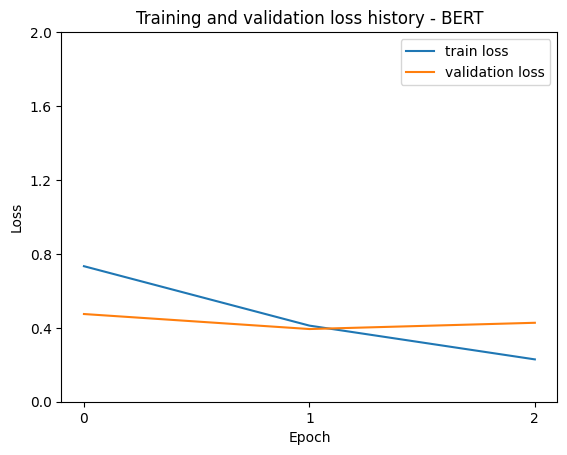

In [36]:
# Visualize from result of training and validation loss of BERT
plt.plot(bert_history['train_loss'], label='train loss')
plt.plot(bert_history['dev_loss'], label='validation loss')

plt.title('Training and validation loss history - BERT')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.xticks(np.arange(0,BERT_EPOCHS, 1))
plt.yticks(np.arange(0,2.05, 0.4))

In [37]:
y_test_b, y_pred_b = predict(bert_model, bert_test_dataloader)

In [38]:
bert_cr = classification_report(np.hstack(y_test_b), np.hstack(y_pred_b), target_names=['Bearish','Bullish', 'Neutral'], output_dict=True)
bert_cr

{'Bearish': {'precision': 0.7395348837209302,
  'recall': 0.7644230769230769,
  'f1-score': 0.7517730496453899,
  'support': 208},
 'Bullish': {'precision': 0.811965811965812,
  'recall': 0.8225108225108225,
  'f1-score': 0.8172043010752688,
  'support': 231},
 'Neutral': {'precision': 0.9154362416107382,
  'recall': 0.9033112582781457,
  'f1-score': 0.9093333333333333,
  'support': 755},
 'accuracy': 0.8634840871021775,
 'macro avg': {'precision': 0.8223123124324935,
  'recall': 0.8300817192373483,
  'f1-score': 0.8261035613513306,
  'support': 1194},
 'weighted avg': {'precision': 0.8647753105478756,
  'recall': 0.8634840871021775,
  'f1-score': 0.8640616872205148,
  'support': 1194}}

In [39]:
print('Accuracy of BERT:', bert_cr['accuracy'])
print('Precision of BERT:',bert_cr['weighted avg']['precision'])
print('Recall of BERT:',bert_cr['weighted avg']['recall'])
print('F1-score of BERT:', bert_cr['weighted avg']['f1-score'])

Accuracy of BERT: 0.8634840871021775
Precision of BERT: 0.8647753105478756
Recall of BERT: 0.8634840871021775
F1-score of BERT: 0.8640616872205148


## Summary ##

I will compare metrics (accuracy, precision, recall and F1-score) of RoBERTa with BERT in this part. This comparison is shown in the table below.

In [40]:
report = {
    "Accuracy": [roberta_cr['accuracy'], bert_cr['accuracy']],
    "Precision": [roberta_cr['weighted avg']['precision'],bert_cr['weighted avg']['precision']],
    "Recall": [roberta_cr['weighted avg']['recall'], bert_cr['weighted avg']['recall']],
    "F1-score": [roberta_cr['weighted avg']['f1-score'], bert_cr['weighted avg']['f1-score']]
}

report_df = pd.DataFrame(report,index=(['RoBERTa (Choice)', 'BERT']))
report_df

,Accuracy,Precision,Recall,F1-score
RoBERTa (Choice),0.887772,0.891005,0.887772,0.888803
BERT,0.863484,0.864775,0.863484,0.864062
